## Combining the file

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import gensim

import warnings
warnings.filterwarnings("ignore")

df1 = pd.read_json('reviews_Video_Games_5.json', lines = True)
df2 = pd.read_json('reviews_Patio_Lawn_and_Garden_5.json', lines = True)
df3 = pd.read_json('reviews_Automotive_5.json', lines = True)

#merging dataframes
final_df = pd.concat([df1, df2, df3])
final_df.shape

#Writing to a new file removing overall rating=3 records to later group (1, 2) as bad and (4, 5) as good
final_df = final_df[final_df['overall'].isin([1,2,4,5])]
final_df.to_csv('reviews.csv', index=False)


## 1. Data Preprocessing

#### 1.a. Initial Exploration

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
import re
import contractions
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report



#reading above created file
df = pd.read_csv('reviews.csv')
print(f'Data has {df.shape[0]} rows and {df.shape[1]} columns')
df.head(5)  

Data has 234161 rows and 9 columns


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1,Wrong key,1403913600,"06 28, 2014"
3,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4,DIRT 3,1308009600,"06 14, 2011"
4,A2UTRVO4FDCBH6,0700099867,A.R.G.,"[0, 0]","Overall this is a well done racing game, with ...",4,"Good racing game, terrible Windows Live Requir...",1368230400,"05 11, 2013"


In [3]:
#bad reviews - 0
df.loc[df['overall'].isin([1, 2]), 'overall'] = 0

#Good reviews - 1
df.loc[df['overall'].isin([4, 5]), 'overall'] = 1

In [4]:
df['overall'].value_counts()

overall
1    203305
0     30856
Name: count, dtype: int64

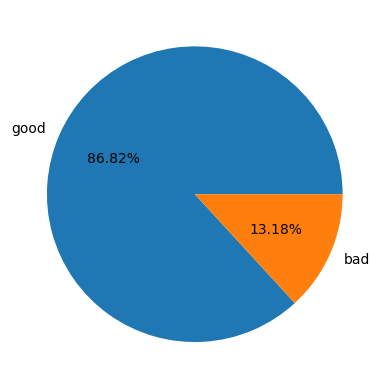

In [5]:


plt.pie(df['overall'].value_counts(), labels = ['good','bad'],autopct = '%1.2f%%')
plt.show()

In [6]:
#dropping non ml attributes
non_ml_attr = ['reviewerID','asin','reviewerName', 'unixReviewTime', 'reviewTime', 'summary']
df.drop(non_ml_attr, axis=1, inplace=True)
df.head(5)

,helpful,reviewText,overall
0,"[8, 12]",Installing the game was a struggle (because of...,0
1,"[0, 0]",If you like rally cars get this game you will ...,1
2,"[0, 0]",1st shipment received a book instead of the ga...,0
3,"[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,1
4,"[0, 0]","Overall this is a well done racing game, with ...",1


In [7]:
import ast

#the helpful column is interpreted as string. converting it to array.

df['helpful'] = df['helpful'].apply(ast.literal_eval)
print(f'''Number of records where 2nd value of "helpful" is less than 1st value of "helpful" : {df[df['helpful'].str[0] > df['helpful'].str[1]].shape[0]}''')
#print(f'''\nNumber of records where 2nd value of "helpful" is 0 but not 1st value of "helpful" : {df[(df['helpful'].str[1] == 0) & (df['helpful'].str[0] != 0)].shape[0]}''')


Number of records where 2nd value of "helpful" is less than 1st value of "helpful" : 0


In [8]:
#creating a helpful ratio : 1st value / 2nd value

df['helpful_ratio'] = df['helpful'].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0)
df.drop(['helpful'], axis = 1, inplace = True)
df.head(5)


,reviewText,overall,helpful_ratio
0,Installing the game was a struggle (because of...,0,0.666667
1,If you like rally cars get this game you will ...,1,0.000000
2,1st shipment received a book instead of the ga...,0,0.000000
3,I had Dirt 2 on Xbox 360 and it was an okay ga...,1,1.000000
4,"Overall this is a well done racing game, with ...",1,0.000000


In [9]:
print('Before:')
print('- No. of rows:',df.shape[0])
print('- Missing value report:')
display(df.isna().sum())

df.dropna(inplace = True)

print('After:')
print('- No. of rows:',df.shape[0])
print('- Missing value report:')
display(df.isna().sum())

Before:
- No. of rows: 234161
- Missing value report:


reviewText       60
overall           0
helpful_ratio     0
dtype: int64

After:
- No. of rows: 234101
- Missing value report:


reviewText       0
overall          0
helpful_ratio    0
dtype: int64

In [10]:
# create review length column

df['review_length'] = df['reviewText'].apply(lambda x: len(x))
df

,reviewText,overall,helpful_ratio,review_length
0,Installing the game was a struggle (because of...,0,0.666667,779
1,If you like rally cars get this game you will ...,1,0.000000,304
2,1st shipment received a book instead of the ga...,0,0.000000,282
3,I had Dirt 2 on Xbox 360 and it was an okay ga...,1,1.000000,294
4,"Overall this is a well done racing game, with ...",1,0.000000,715
...,...,...,...,...
234156,I've bought 10 of these over the past year to ...,1,1.000000,243
234157,"OK, I have to admit, the price of this item di...",0,0.000000,1260
234158,I love my skull face mask. It makes me outstan...,1,0.000000,202
234159,This mask of course as described is half-face ...,1,0.000000,149


#### 1.b. Cleaning and tranforming

In [11]:
stop_words = set(stopwords.words('english'))

#creating a list of words that might actually help in sentiment analysis 
#and removing them from stopwords
x = ['few', 'once', 'same', 'below', 'above', 'during','over', 'after', 'most','before', 'just', 'against','very','no','which','where','what','nor','whom','why','when','down','but', 'not']
for i in x:
    stop_words.remove(i)
print(stop_words)

{'do', "isn't", 'under', 'hadn', 'weren', 'be', 'only', 'yours', 'each', 'other', 'won', 'and', 'with', 'further', 'having', 'at', "weren't", 'an', 'own', 'does', "aren't", 'its', 'from', 'shouldn', 'by', 'we', "you've", "that'll", 'isn', 'out', 'some', "doesn't", 'was', 'both', 'these', 'wasn', 's', "wasn't", 'doesn', 'me', 'my', 'it', 'mustn', 'than', 'couldn', 'll', 'on', 'yourselves', 'those', 'or', 'here', 'is', 'there', 'up', 'has', 'off', 'so', "hadn't", 'myself', "she's", 'any', 'their', 'himself', 'such', 'ours', 've', "you'd", 'doing', 'her', 'into', 'through', 'all', 'shan', 'between', 'a', 'been', "mustn't", 'theirs', 'they', 'o', 'while', "wouldn't", 'how', "don't", 'y', 'am', 'about', 'them', 're', 'if', 'the', 'ma', "mightn't", 'm', 'our', 'itself', 'yourself', 'you', 'to', 'who', 'of', 'again', 'can', 'as', 'were', 'don', 'ourselves', 'hers', 'have', 't', 'd', "shouldn't", "couldn't", "didn't", 'being', "it's", 'will', 'haven', 'herself', 'wouldn', 'for', 'she', "needn'

In [12]:
def preprocess_text(text):
    '''
    preprocessing the required text column to convert case, remove number, remove contractions and stopwords
    '''
    # Convert to lower case
    text = text.lower()
    
    ## add space inbetween numbers and letters (e.g. 5mg to 5 mg, 17yo to 17 yo)
    text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text)
    
    #remove numbers
    text = re.sub(r'\d+', '', text)

    # Expand contractions (e.g., "can't" to "can not")
    text = contractions.fix(text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Apply stopwords list
    #stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    

    return text

In [13]:
#preprocessing text
df['preprocessed_text'] = df['reviewText'].apply(lambda x: preprocess_text(x))
df['preprocessed_text'].head(3)

0    installing game struggle games windows live bu...
1    like rally cars get game fun oriented european...
2    st shipment received book instead game nd ship...
Name: preprocessed_text, dtype: object

In [14]:
#getting list of rare words - words that occur only once.
#This might help in eliminating typos
text = ' '.join(df['preprocessed_text'])
text = text.split()
freq_comm = pd.Series(text).value_counts()
rare = freq_comm[freq_comm.values == 1]
rare.index.tolist()[:10]

['handmultiple',
 'daaaah',
 'blockishness',
 'storycould',
 'atoned',
 'soundtracknegative',
 'includedwell',
 'playeddante',
 'serieshelicopter',
 'eace']

In [15]:
def remove_rare(text):
    '''
    function to remove rare words
    '''
    text = ' '.join([word for word in text.split() if word not in rare])
    
    return text

In [16]:
#removing the above rare words:

df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: remove_rare(x))
df['preprocessed_text'].head(3)


0    installing game struggle games windows live bu...
1    like rally cars get game fun oriented european...
2    st shipment received book instead game nd ship...
Name: preprocessed_text, dtype: object

In [17]:
#creating list of words.
#each element is a list of words in a sentence.

words = []
for i in df['preprocessed_text'].values:
    words.append(i.split())
print(words[:3])

[['installing', 'game', 'struggle', 'games', 'windows', 'live', 'bugs', 'championship', 'races', 'cars', 'unlocked', 'buying', 'addon', 'game', 'paid', 'nearly', 'dollars', 'when', 'game', 'new', 'not', 'like', 'idea', 'keep', 'paying', 'keep', 'playing', 'noticed', 'no', 'improvement', 'physics', 'graphics', 'compared', 'dirt', 'tossed', 'garbage', 'vowed', 'never', 'buy', 'another', 'codemasters', 'game', 'really', 'tired', 'arcade', 'style', 'rally', 'racing', 'games', 'anyway', 'continue', 'get', 'fix', 'richard', 'burns', 'rally', 'http', 'www', 'amazon', 'com', 'richard', 'burns', 'rally', 'pc', 'dp', 'b', 'c', 'ref', 'sr', 'ie', 'utf', 'qid', 'sr', 'keywords', 'richard', 'burns', 'reading', 'review', 'enjoyed', 'sure', 'rate', 'helpful'], ['like', 'rally', 'cars', 'get', 'game', 'fun', 'oriented', 'european', 'market', 'since', 'america', 'not', 'huge', 'rally', 'fan', 'party', 'music', 'very', 'european', 'even', 'voices', 'game', 'very', 'english', 'accent', 'multiplayer', 'no

In [18]:
#creating review preprocessed text column - as there are a few texts of length 0
df['processed_len'] = df['preprocessed_text'].apply(lambda x: len(x))

#printing rows where length of preprocessed text is 0
df[df['processed_len'] == 0]

,reviewText,overall,helpful_ratio,review_length,preprocessed_text,processed_len
113556,awewsome,1,0.0,8,,0
154521,as expeceted,1,0.0,12,,0
212609,They are perfedt.,1,0.0,17,,0


In [19]:
#removing those
print('Before:', df.shape[0])
df = df[df['processed_len'] != 0]
print('After:', df.shape[0])

Before: 234101
After: 234098


## 2. Embeddings

#### vectors and embeddings covered.

In [3]:

def create_w2v(embedding_dim, words, window, epochs, sg):
    '''
    creating word2vec or skipgram.
    '''
    #Creating Word2Vec
    w2v_model = gensim.models.Word2Vec(words , vector_size = embedding_dim , window = window , min_count = 1, epochs = epochs, sg = sg)
    print(f"- {'Word2Vec' if(sg==0) else 'Skipgram'} Created")
    print(f'- Vocabulary count: {len(w2v_model.wv)}')
    print(f'''- Similar words for word "great:\n"{w2v_model.wv.most_similar('great')}''')
    
    return w2v_model
    

def get_sentence_embedding(sent, model, flag):
    '''
    create embeddings by calculating mean of vectors of words in each review (preprocessed_text)
    '''
    list_vectors = []
    for word in sent:
        if(flag):
            #indicates fasttext
            vector = model.get_word_vector(word)
        else:
            vector = model.wv[word]
        list_vectors.append(vector)
    mean_vector = np.array(list_vectors).mean(axis=0)
    return mean_vector


# Creating "embeddings" column
def get_embedding_cols(df, embedding_dim, model, flag):
    '''
    returns df with embedded columns. flag indicates if its fasttext
    '''
    #df['embeddings'] = df['preprocessed_text'].apply(lambda x: get_sentence_embedding(x.split(), model))
    df['embeddings'] = df['preprocessed_text'].apply(lambda x: get_sentence_embedding(x.split(), model, flag))
    

    #creating a column for each vector in embedding - 100 columns
    cols = [f'e_{i}' for i in range(1, embedding_dim + 1)]
    df[cols] = pd.DataFrame(df['embeddings'].tolist(), index= df.index)
    print('- Embeddings are created.')
    return df


def build_model(estimator, X, y):
    '''
    builds model based on estimator, X and y values.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

    # Create a pipeline with StandardScaler and XGBoost
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # StandardScaler for scaling features
        ('est', estimator)       # XGBoost classifier (or regressor)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    print(f"- Model is trained using {str(pipeline.named_steps['est']).split('(')[0]}")
    
    # Train Scores
    print(f'- Train Scores:')
    get_scores(pipeline, X_train, y_train)

    # Test Scores
    print(f'- Test Scores:')
    get_scores(pipeline, X_test, y_test)


#### Fasttext - 100 embeddings

In [21]:
df.to_csv('text_label.txt', columns = ['preprocessed_text'], header = None, index = False)

In [22]:
import fasttext

model = fasttext.train_unsupervised('text_label.txt', dim = 100)

print(f'FASTTEXT {model.dim} VECTOR EMBEDDING DIMENSIONS:')
print(f'=========================================')

ft_df_100 = get_embedding_cols(df, 100, model, True)

#writing to a new file
ft_df_100.to_csv('fasttext_100_dim.csv', index = False)

print('- Fasttext embeddings Created')
print(f'- Vocabulary count: {len(model.words)}')
print(f'''- Similar words for word "great:\n"{model.get_nearest_neighbors('great', k=10)}''')


Read 24M words
Number of words:  49568
Number of labels: 0
Progress: 100.0% words/sec/thread:   70001 lr:  0.000000 avg.loss:  1.223200 ETA:   0h 0m 0s words/sec/thread:   73747 lr:  0.021287 avg.loss:  1.868462 ETA:   0h 1m40s


FASTTEXT 100 VECTOR EMBEDDING DIMENSIONS:
- Embeddings are created.
- Fasttext embeddings Created
- Vocabulary count: 49568
- Similar words for word "great:
"[(0.8940829038619995, 'good'), (0.8841949701309204, 'excellent'), (0.854091465473175, 'excelllent'), (0.839653491973877, 'well'), (0.8280909061431885, 'fantastic'), (0.8223187327384949, 'nice'), (0.807611346244812, 'greatit'), (0.7990691065788269, 'awesome'), (0.7882174253463745, 'amazing'), (0.7877129912376404, 'outstanding')]


#### Word2Vec - 100 embeddings

In [23]:
 
print(f'\nWORD2VEC 100 VECTOR EMBEDDING DIMENSIONS:')
print(f'=========================================')

#word2vec
w2v_model = create_w2v(100, words, 7, 50, sg = 0)

df1 = df.copy()

#creating embedding columns
df1 = get_embedding_cols(df1, 100, w2v_model, False)
df1.to_csv(f'word2vec_100_dim.csv', index = False)



WORD2VEC 100 VECTOR EMBEDDING DIMENSIONS:
- Word2Vec Created
- Vocabulary count: 86922
- Similar words for word "great:
"[('excellent', 0.8609936237335205), ('fantastic', 0.8301099538803101), ('terrific', 0.8080956935882568), ('awesome', 0.8027114272117615), ('wonderful', 0.7724308967590332), ('good', 0.7695636749267578), ('amazing', 0.7612894177436829), ('outstanding', 0.7566025257110596), ('fabulous', 0.7259987592697144), ('superb', 0.7128263115882874)]
- Embeddings are created.


#### Skipgram - 100 embeddigs

In [24]:
  
print(f'\nSKIPGRAM 100 VECTOR EMBEDDING DIMENSIONS:')
print(f'=========================================')

#word2vec
sg_model = create_w2v(100, words, 7, 50, sg = 1)

df1 = df.copy()

#creating embedding columns
df1 = get_embedding_cols(df1, 100, sg_model, False)

df1.to_csv(f'skipgram_100_dim.csv', index = False)  


SKIPGRAM 100 VECTOR EMBEDDING DIMENSIONS:
- Skipgram Created
- Vocabulary count: 86922
- Similar words for word "great:
"[('good', 0.900197446346283), ('excellent', 0.792664110660553), ('well', 0.7846163511276245), ('nice', 0.7833895087242126), ('really', 0.7510595321655273), ('perfect', 0.7405424118041992), ('like', 0.7147427797317505), ('also', 0.7086318135261536), ('love', 0.7054932713508606), ('just', 0.6993326544761658)]
- Embeddings are created.


#### 2.c. EDA

In [233]:
#analysing 300 vectors

wv = pd.read_csv('word2vec_100_dim.csv')
sg = pd.read_csv('skipgram_100_dim.csv')
ft = pd.read_csv('fasttext_100_dim.csv')

In [234]:
from sklearn.metrics.pairwise import cosine_similarity

X = wv.drop(['reviewText', 'overall', 'helpful_ratio', 'review_length',
       'preprocessed_text', 'processed_len', 'embeddings'], axis = 1).head(10)

Y = sg.drop(['reviewText', 'overall', 'helpful_ratio', 'review_length',
       'preprocessed_text', 'processed_len', 'embeddings'], axis = 1).head(10)

Z = ft.drop(['reviewText', 'overall', 'helpful_ratio', 'review_length',
       'preprocessed_text', 'processed_len', 'embeddings'], axis = 1).head(10)

In [235]:
xy = []
yz = []
xz = []
for i in range(X.shape[0]):
    xy.append(cosine_similarity([X.values[i]], [Y.values[i]])[0][0])
    yz.append(cosine_similarity([Y.values[i]], [Z.values[i]])[0][0])
    xz.append(cosine_similarity([X.values[i]], [Z.values[i]])[0][0])

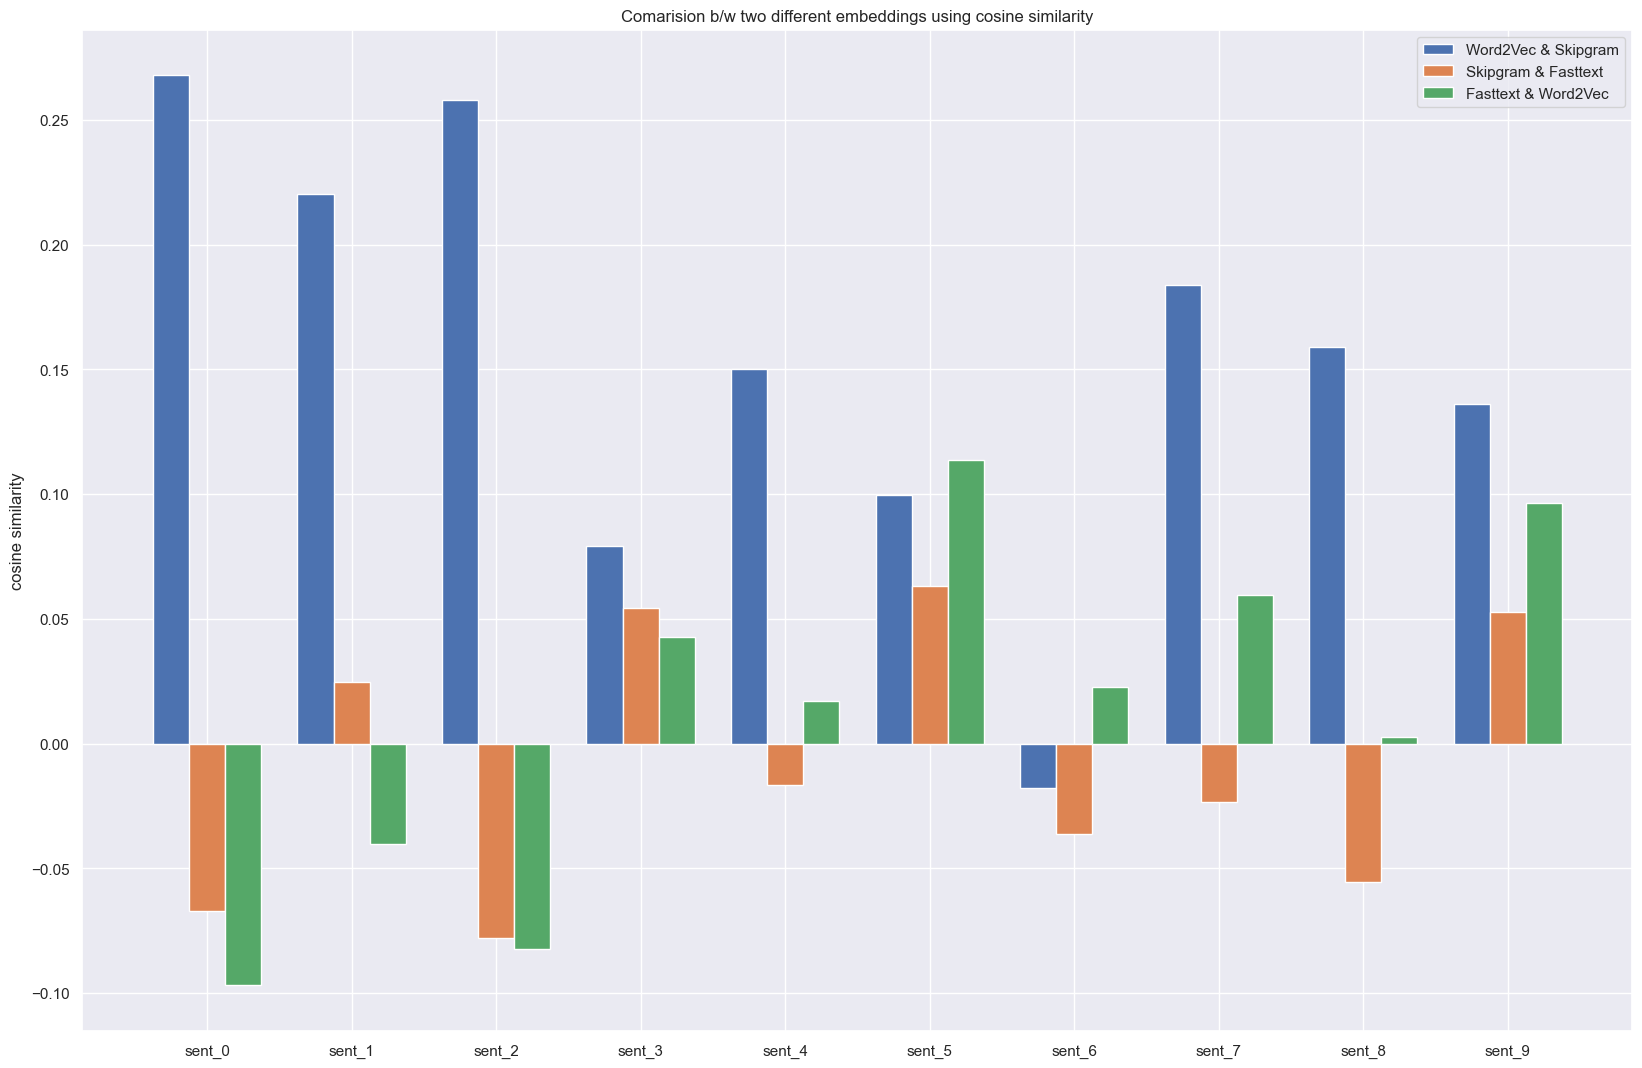

In [236]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

sentences = [f'sent_{i}' for i in range(10)]
similarities = {
    'Word2Vec & Skipgram': xy[:10],
    'Skipgram & Fasttext': yz[:10],
    'Fasttext & Word2Vec': xz[:10],
}

x = np.arange(len(sentences))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

sns.set_style("darkgrid")

fig, ax = plt.subplots()
fig.set_figheight(13)
fig.set_figwidth(20)
for attribute, measurement in similarities.items():
    offset = width * multiplier
    ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('cosine similarity')
ax.set_title('Comarision b/w two different embeddings using cosine similarity')
ax.set_xticks(x + width, sentences)
ax.legend()

plt.show()

In [30]:
ft_great = []
for i in model.get_nearest_neighbors('great', k = 50):
    if(i[1] in text):
        ft_great.append(i)
    if(len(ft_great) == 10):
        break

sg_great = [('good', 0.7812654972076416), ('excellent', 0.7262212038040161), ('nice', 0.6465476155281067), ('really', 0.6356357336044312), ('fantastic', 0.6268095374107361), ('awesome', 0.62676602602005), ('well', 0.6153631806373596), ('also', 0.6040209531784058), ('like', 0.6032633781433105), ('love', 0.6010682582855225)]
wv_great = [('excellent', 0.8213387727737427), ('fantastic', 0.7905341386795044), ('awesome', 0.7666008472442627), ('good', 0.7290399670600891), ('wonderful', 0.7195278406143188), ('amazing', 0.7172749042510986), ('terrific', 0.7113191485404968), ('outstanding', 0.6923202276229858), ('superb', 0.6464500427246094), ('incredible', 0.619756281375885)]


x = pd.DataFrame(data=ft_great, columns = ['similarity_to_great', 'word'])
y = pd.DataFrame(data=sg_great, columns = ['word','similarity_to_great'])
z = pd.DataFrame(data=wv_great, columns = ['word','similarity_to_great'])


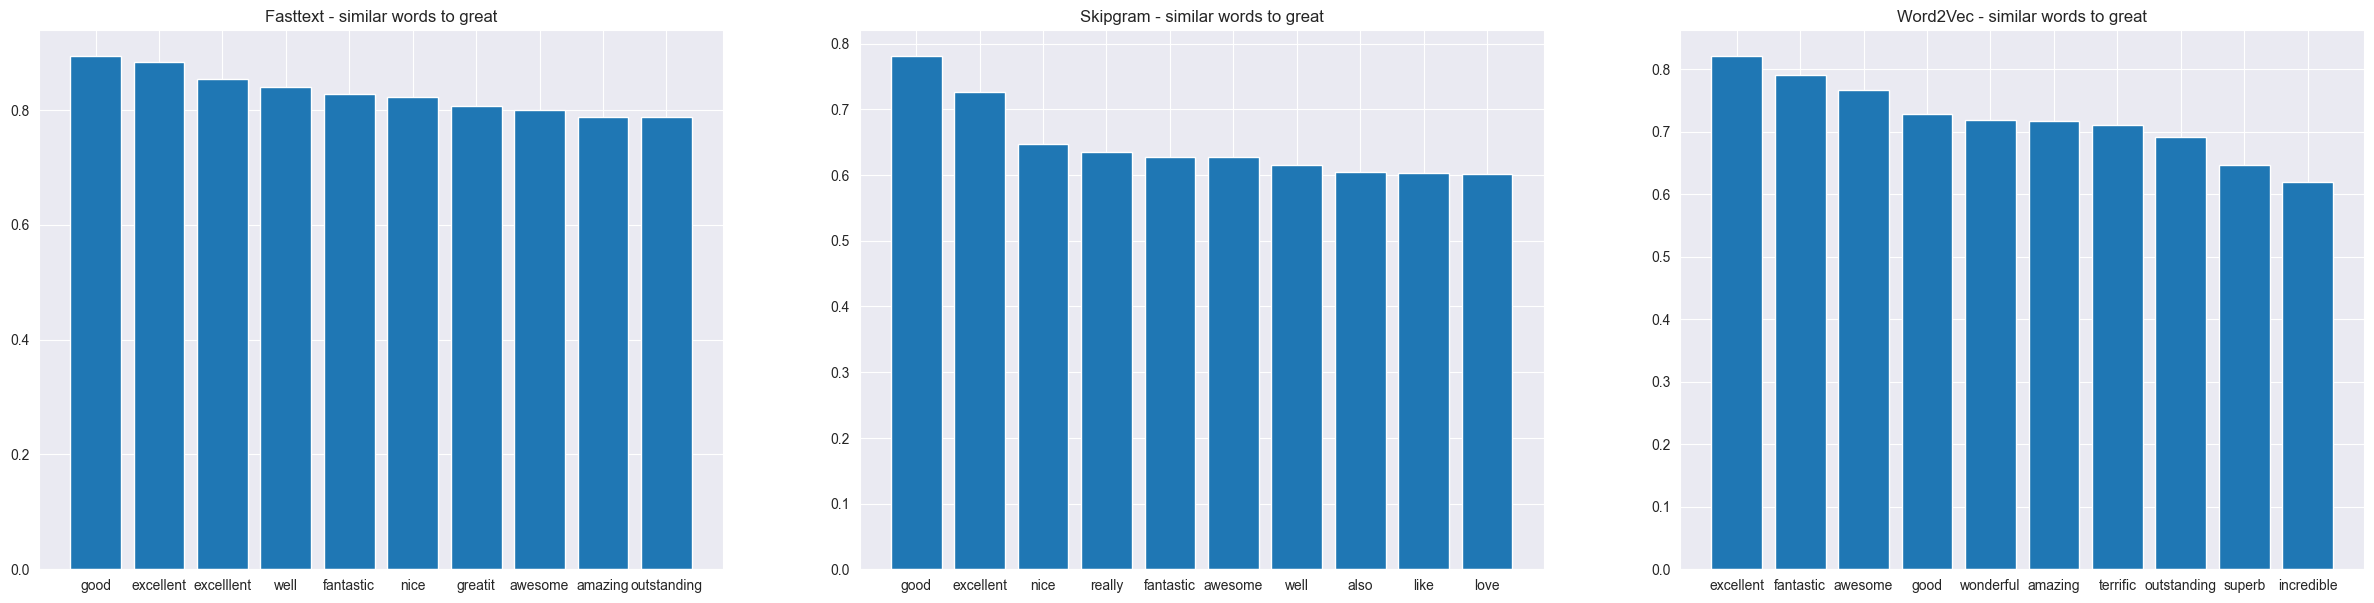

In [31]:
fig, ax = plt.subplots(1, 3)
fig.set_figheight(7)
fig.set_figwidth(30)
ax[0].bar(x['word'], x['similarity_to_great'])
ax[0].set_title('Fasttext - similar words to great')

ax[1].bar(y['word'], y['similarity_to_great'])
ax[1].set_title('Skipgram - similar words to great')

ax[2].bar(z['word'], z['similarity_to_great'])
ax[2].set_title('Word2Vec - similar words to great')

plt.show() 

## 3. Modelling

- rating is already converted to binary.

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

wv = pd.read_csv('word2vec_100_dim.csv')
sg = pd.read_csv('skipgram_100_dim.csv')
ft = pd.read_csv('fasttext_100_dim.csv')

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

def calc_metrics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    return accuracy, precision, recall, f1

def get_scores(model, X_train,y_train, X_test, y_test):
    # Make predictions on the training set
    sns.set(style="darkgrid")

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))  # 1 row, 2 columns

    y_pred = model.predict(X_train)

    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    print("- Train Accuracy:", accuracy)
    print("- Train Precision:", precision)
    print("- Train Recall:", recall)
    print("- Train F1 Score:", f1)
    
    #print(classification_report(y, y_pred))

    # Calculate confusion matrix
    cm1 = confusion_matrix(y_train, y_pred)

    # Plot the confusion matrix
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", ax = axes[0])
    axes[0].set_title("Confusion Matrix - Train")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\n- Test Accuracy:", accuracy)
    print("- Test Precision:", precision)
    print("- Test Recall:", recall)
    print("- Test F1 Score:", f1)
    
    #print(classification_report(y, y_pred))

    # Calculate confusion matrix
    cm2 = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", ax = axes[1])
    axes[1].set_title("Confusion Matrix - Test")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)


    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[2].legend(loc="lower right")
    
    plt.show()
    
    return [accuracy, precision, recall, f1, roc_auc]
    
def get_roc_auc(y_test, y_pred_proba):

    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [3]:
scores_data = []

### XGBClassifier - Method 1

#### Exploring UMAP

- Train Accuracy: 0.698304125417828
- Train Precision: 0.9548338420384787
- Train Recall: 0.6849158369259721
- Train F1 Score: 0.7976593359762496

- Test Accuracy: 0.6110209312259718
- Test Precision: 0.8818624280997924
- Test Recall: 0.6373766943002632
- Test F1 Score: 0.7399474525931004


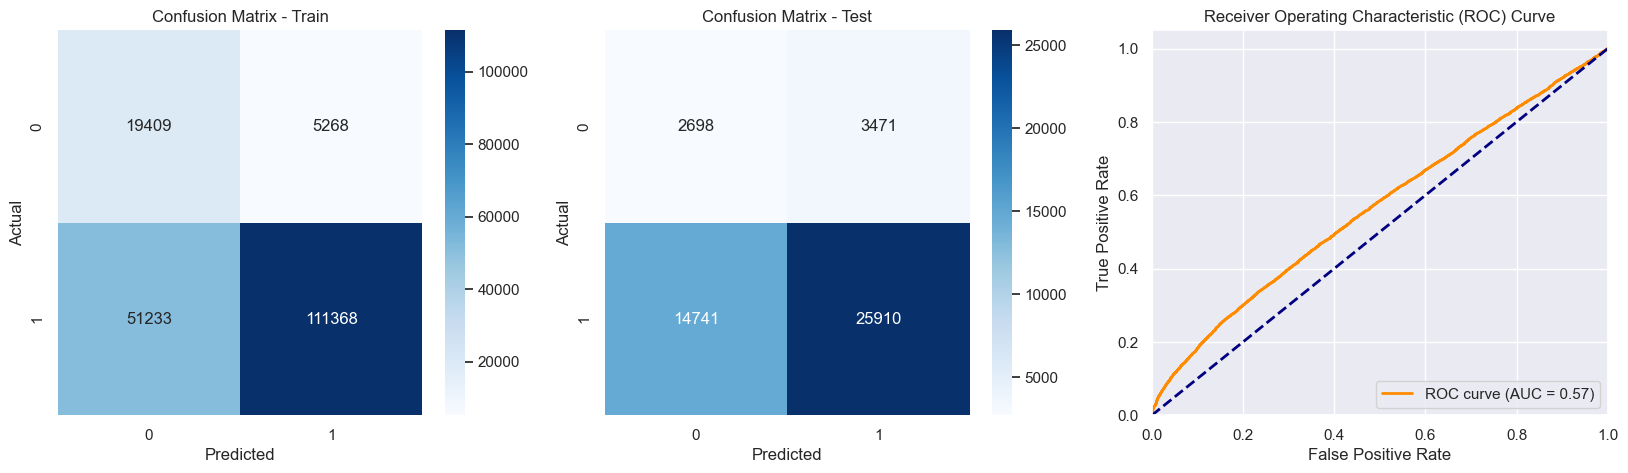

<Figure size 800x600 with 0 Axes>

[0.6110209312259718,
 0.8818624280997924,
 0.6373766943002632,
 0.7399474525931004,
 0.5658162194527858]

In [61]:

import umap

X = wv.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = wv['overall']

red = umap.UMAP(n_components = 100, n_neighbors = 250, min_dist = 0.3)

red_X = pd.DataFrame(data = red.fit_transform(X), columns = [f'umap{i+1}' for i in range(100)])


X_train, X_test, y_train, y_test = train_test_split(red_X, y, test_size=0.2, random_state=42, stratify = y)

# Create a pipeline with  for dimensionality reduction and XGBoost for modeling
pipeline = Pipeline([
    ('xgb', XGBClassifier(random_state = 42, max_depth = 9, scale_pos_weight = 0.15176234428197508, eval_metric='auc', max_delta_step = 6, subsample = 0.5))
])


pipeline.fit(X_train, y_train)
get_scores(pipeline, X_train, y_train, X_test, y_test)

-  we can see that reducing components from even 103 to 100 is giving an roc score of 0.56. This was the same for us even in the cases where we used other dimensionality reduction techniques - PCA, T-SNE, TruncatedSVD. So, decided against using dimensionality reduction

#### XGBClassifier - CBOW

{'xgb__max_delta_step': 4, 'xgb__max_depth': 9, 'xgb__subsample': 0.5}
- Train Accuracy: 0.9765268744860581
- Train Precision: 0.9995389988064489
- Train Recall: 0.9734134476417734
- Train F1 Score: 0.9863032478376829

- Test Accuracy: 0.9075822298163179
- Test Precision: 0.9555533259757198
- Test Recall: 0.9371479176404024
- Test F1 Score: 0.9462611309132006


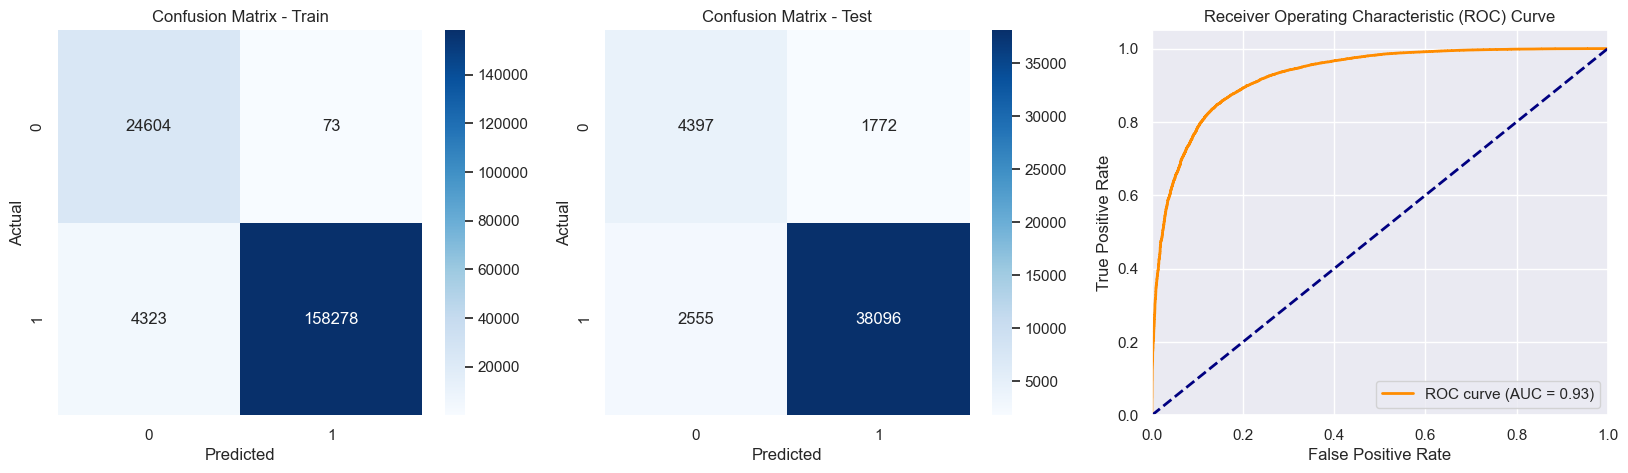

<Figure size 800x600 with 0 Axes>

In [4]:

# Separate features and target
X = wv.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = wv['overall']

# Define the parameter grid for XGBClassifier
param_grid = {
    'xgb__max_depth': [6, 9],
    'xgb__max_delta_step': [4, 6],
    'xgb__subsample': [0.5],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline with train_test_split and XGBClassifier
pipeline = Pipeline([
    #Dimension reduction step if we use it.
    ('xgb', XGBClassifier(random_state = 42, eval_metric='auc', scale_pos_weight = 0.15176234428197508))])

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_

print(best_params)
best_estimator = grid_search.best_estimator_

scores_data.append(['XGBoost', 'CBOW'] + get_scores(best_estimator, X_train, y_train, X_test, y_test))


#### XGBClassifier - Skipgram

{'xgb__max_delta_step': 4, 'xgb__max_depth': 9, 'xgb__subsample': 0.5}
- Train Accuracy: 0.975976889971059
- Train Precision: 0.9995955255008532
- Train Recall: 0.9727246449898832
- Train F1 Score: 0.9859770408719856

- Test Accuracy: 0.9064075181546347
- Test Precision: 0.9548065106713817
- Test Recall: 0.9365329266192713
- Test F1 Score: 0.9455814415577964


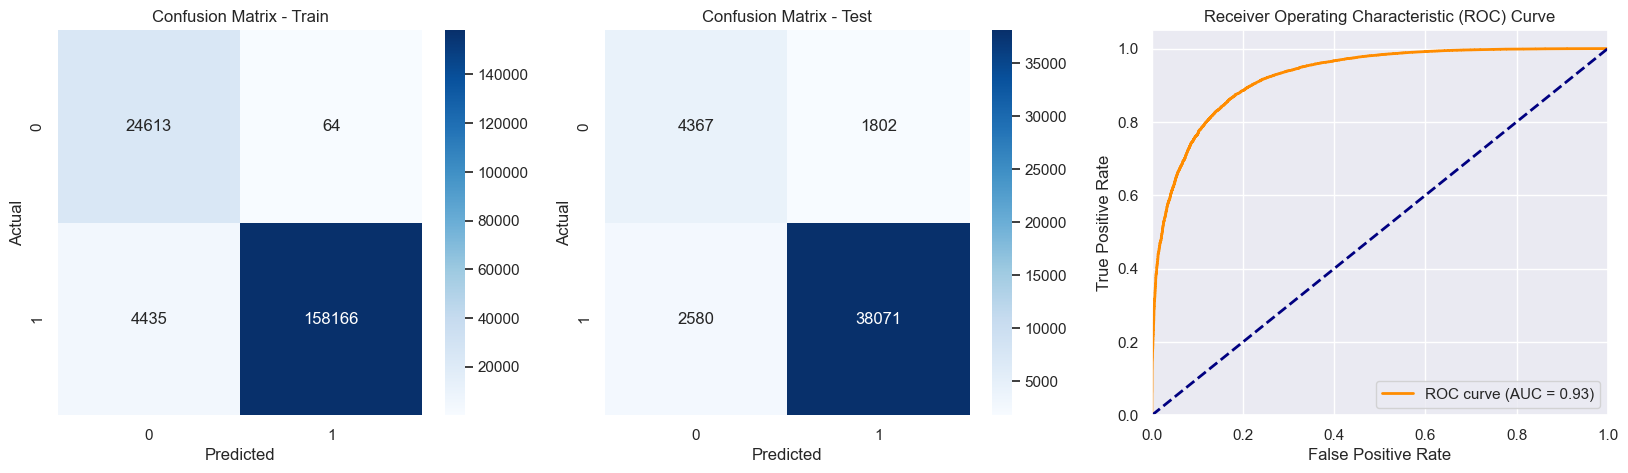

<Figure size 800x600 with 0 Axes>

In [5]:

# Separate features and target
X = sg.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = sg['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Define the parameter grid for XGBClassifier
param_grid = {
    'xgb__max_depth': [6, 9],
    'xgb__max_delta_step': [4, 6],
    'xgb__subsample': [0.5]
}


# Create a pipeline with train_test_split and XGBClassifier
pipeline = Pipeline([
    #Dimension reduction step if we use it.
    ('xgb', XGBClassifier(random_state = 42, eval_metric='auc', scale_pos_weight = 0.15176234428197508))])

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_

print(best_params)
best_estimator = grid_search.best_estimator_

scores_data.append(['XGBoost', 'Skipgram'] + get_scores(best_estimator, X_train, y_train, X_test, y_test))


#### XGBClassifier - Fasttext

{'xgb__max_delta_step': 4, 'xgb__max_depth': 9, 'xgb__subsample': 0.5}
- Train Accuracy: 0.9760196072149425
- Train Precision: 0.9995387220705692
- Train Recall: 0.9728291953924023
- Train F1 Score: 0.9860031104199067

- Test Accuracy: 0.9072832123024348
- Test Precision: 0.9549441186788954
- Test Recall: 0.9374431133305454
- Test F1 Score: 0.9461126903931377


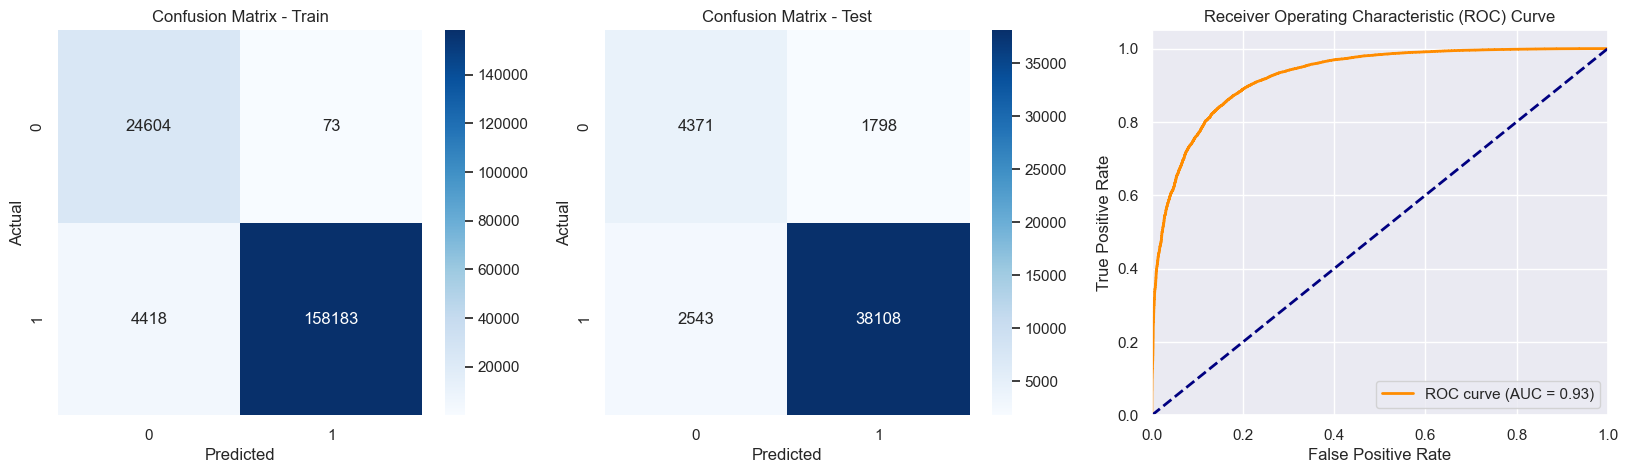

<Figure size 800x600 with 0 Axes>

In [6]:

# Separate features and target
X = ft.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = ft['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Define the parameter grid for XGBClassifier
param_grid = {
    'xgb__max_depth': [6, 9],
    'xgb__max_delta_step': [4, 6],
    'xgb__subsample': [0.5]
}


# Create a pipeline with train_test_split and XGBClassifier
pipeline = Pipeline([
    #Dimension reduction step if we use it.
    ('xgb', XGBClassifier(random_state = 42, eval_metric='auc', scale_pos_weight = 0.15176234428197508))])

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_

print(best_params)
best_estimator = grid_search.best_estimator_

scores_data.append(['XGBoost', 'Fasttext'] + get_scores(best_estimator, X_train, y_train, X_test, y_test))


### CNN

#### CNN with CBOW

Epoch 1/10
   1/1464 [..............................] - ETA: 10:29 - loss: 10.5604 - accuracy: 0.1484

2024-03-16 20:20:59.816573: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 20s 13ms/step - loss: 293202496.0000 - accuracy: 0.7886 - val_loss: 260028352.0000 - val_accuracy: 0.8755
Epoch 2/10
1464/1464 [==============================] - 21s 14ms/step - loss: 464091744.0000 - accuracy: 0.8348 - val_loss: 155352944.0000 - val_accuracy: 0.8870
Epoch 3/10
1464/1464 [==============================] - 18s 12ms/step - loss: 381559328.0000 - accuracy: 0.8416 - val_loss: 1070171456.0000 - val_accuracy: 0.8683
Epoch 4/10
1464/1464 [==============================] - 18s 13ms/step - loss: 355372928.0000 - accuracy: 0.8424 - val_loss: 394017920.0000 - val_accuracy: 0.8743
Epoch 5/10
1464/1464 [==============================] - 19s 13ms/step - loss: 411859328.0000 - accuracy: 0.8367 - val_loss: 1991009792.0000 - val_accuracy: 0.3183
Epoch 6/10
1464/1464 [==============================] - 18s 12ms/step - loss: 318834464.0000 - accuracy: 0.8442 - val_loss: 597734528.0000 - val_accuracy: 0.8694
Epoch 7/10
1464/1464 [===============

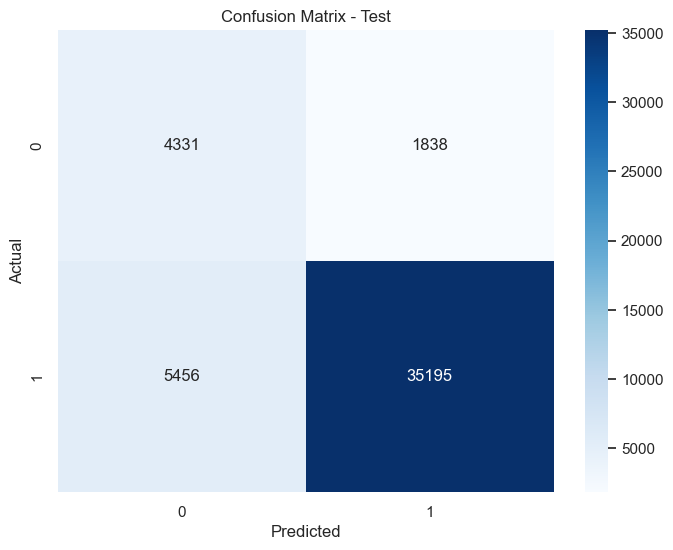

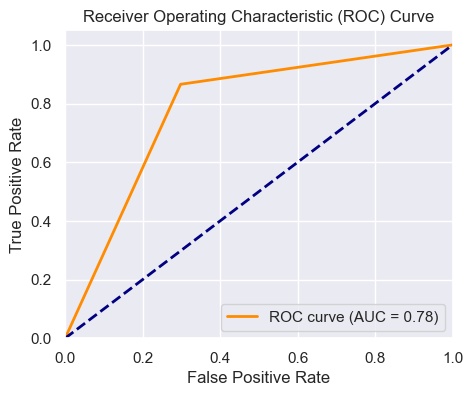

In [13]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.utils import set_random_seed

set_random_seed(84)

X = wv.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = wv['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Adjust layer size based on your needs
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.8), metrics=['accuracy'] )


X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)


model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


yhat_probs = model.predict(X_test, verbose=0)
yhat_probs = yhat_probs[:, 0]
y_pred = pd.Series(yhat_probs).apply(lambda x: 1 if x > 0.5 else 0)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)

roc_auc = get_roc_auc(y_test, yhat_probs)

scores_data.append(['CNN', 'CBOW']+[accuracy, precision, recall, f1, roc_auc])

#### CNN with Skipgram

Epoch 1/10
   1/1464 [..............................] - ETA: 10:30 - loss: 3.5003 - accuracy: 0.8594

2024-03-16 20:24:28.972529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 20s 13ms/step - loss: 18249830.0000 - accuracy: 0.7777 - val_loss: 8097322.0000 - val_accuracy: 0.5407
Epoch 2/10
1464/1464 [==============================] - 19s 13ms/step - loss: 17963970.0000 - accuracy: 0.7712 - val_loss: 15314113.0000 - val_accuracy: 0.1362
Epoch 3/10
1464/1464 [==============================] - 18s 12ms/step - loss: 16856296.0000 - accuracy: 0.7861 - val_loss: 2857982.5000 - val_accuracy: 0.8421
Epoch 4/10
1464/1464 [==============================] - 19s 13ms/step - loss: 13963369.0000 - accuracy: 0.8055 - val_loss: 6597172.0000 - val_accuracy: 0.8740
Epoch 5/10
1464/1464 [==============================] - 20s 14ms/step - loss: 14585778.0000 - accuracy: 0.8071 - val_loss: 31934392.0000 - val_accuracy: 0.8684
Epoch 6/10
1464/1464 [==============================] - 19s 13ms/step - loss: 13502838.0000 - accuracy: 0.8142 - val_loss: 24883222.0000 - val_accuracy: 0.8696
Epoch 7/10
1464/1464 [==============================] 

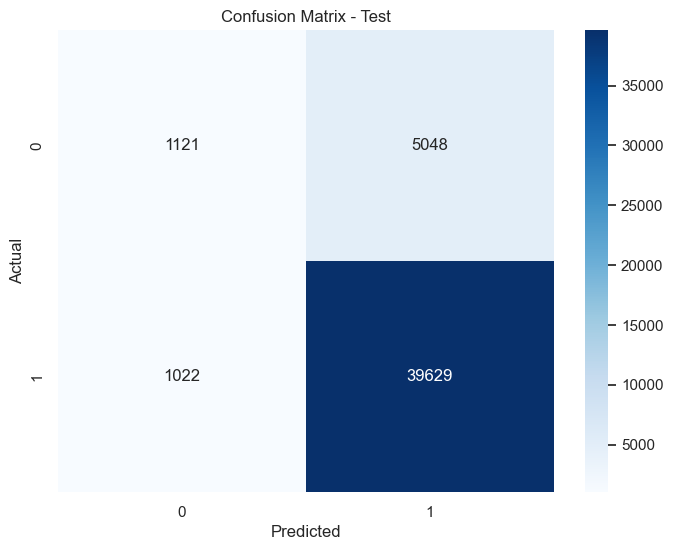

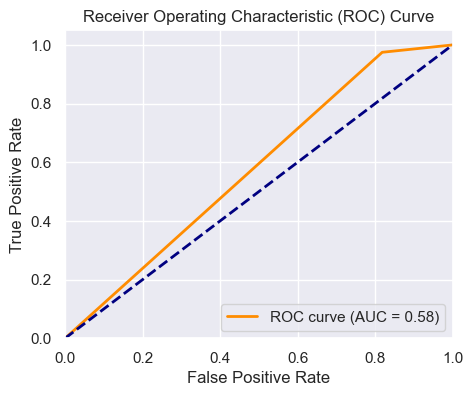

In [14]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.utils import set_random_seed

set_random_seed(33)

X = sg.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = sg['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Adjust layer size based on your needs
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.3), metrics=['accuracy'] )


X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)


model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


yhat_probs = model.predict(X_test, verbose=0)
yhat_probs = yhat_probs[:, 0]
y_pred = pd.Series(yhat_probs).apply(lambda x: 1 if x > 0.5 else 0)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)

roc_auc = get_roc_auc(y_test, yhat_probs)

scores_data.append(['CNN', 'Skipgram']+[accuracy, precision, recall, f1, roc_auc])

#### CNN with Fasttext

Epoch 1/10


2024-03-16 20:27:44.189175: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 20s 13ms/step - loss: 13.3031 - accuracy: 0.7682 - val_loss: 49.4532 - val_accuracy: 0.8682
Epoch 2/10
1464/1464 [==============================] - 18s 12ms/step - loss: 185.3499 - accuracy: 0.7732 - val_loss: 31.4935 - val_accuracy: 0.8676
Epoch 3/10
1464/1464 [==============================] - 18s 12ms/step - loss: 41.4824 - accuracy: 0.7865 - val_loss: 9.2371 - val_accuracy: 0.8729
Epoch 4/10
1464/1464 [==============================] - 18s 12ms/step - loss: 27.4809 - accuracy: 0.8207 - val_loss: 18.6920 - val_accuracy: 0.8531
Epoch 5/10
1464/1464 [==============================] - 18s 12ms/step - loss: 46.0716 - accuracy: 0.8151 - val_loss: 46.5843 - val_accuracy: 0.8708
Epoch 6/10
1464/1464 [==============================] - 18s 13ms/step - loss: 53.6366 - accuracy: 0.8154 - val_loss: 29.0211 - val_accuracy: 0.8724
Epoch 7/10
1464/1464 [==============================] - 18s 12ms/step - loss: 50.7251 - accuracy: 0.8158 - val_loss: 129.00

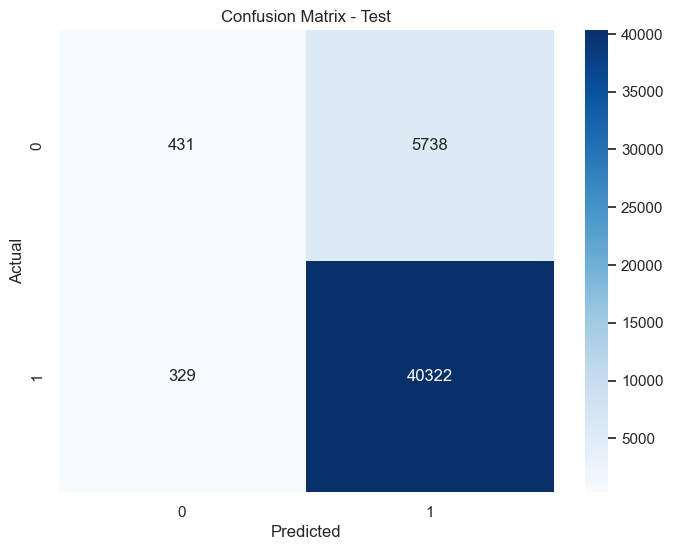

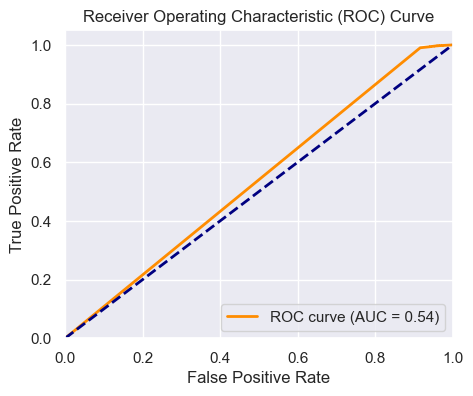

In [15]:
set_random_seed(22)

X = ft.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = ft['overall']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Adjust layer size based on your needs
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.01), metrics=['accuracy'] )


X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)


model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


yhat_probs = model.predict(X_test, verbose=0)
yhat_probs = yhat_probs[:, 0]
y_pred = pd.Series(yhat_probs).apply(lambda x: 1 if x > 0.5 else 0)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)

roc_auc = get_roc_auc(y_test, yhat_probs)

scores_data.append(['CNN', 'Fasttext']+[accuracy, precision, recall, f1, roc_auc])


### RNN

#### RNN - CBOW

2024-03-16 20:33:29.237336: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-16 20:33:29.237402: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-16 20:33:29.237429: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-16 20:33:29.237726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 20:33:29.237995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-03-16 20:33:30.535303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-16 20:33:30.625253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 44s 29ms/step - loss: 0.3280 - accuracy: 0.8743 - val_loss: 0.2897 - val_accuracy: 0.8803
Epoch 2/10
1464/1464 [==============================] - 43s 29ms/step - loss: 0.2793 - accuracy: 0.8885 - val_loss: 0.2704 - val_accuracy: 0.8949
Epoch 3/10
1464/1464 [==============================] - 38s 26ms/step - loss: 0.2646 - accuracy: 0.8944 - val_loss: 0.2571 - val_accuracy: 0.8991
Epoch 4/10
1464/1464 [==============================] - 44s 30ms/step - loss: 0.3024 - accuracy: 0.8891 - val_loss: 0.3934 - val_accuracy: 0.8682
Epoch 5/10
1464/1464 [==============================] - 38s 26ms/step - loss: 0.3918 - accuracy: 0.8682 - val_loss: 0.3906 - val_accuracy: 0.8682
Epoch 6/10
1464/1464 [==============================] - 37s 26ms/step - loss: 0.3691 - accuracy: 0.8689 - val_loss: 0.3014 - val_accuracy: 0.8777
Epoch 7/10
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2886 - accuracy: 0.8831 - val_loss: 0.2829 - val_accura

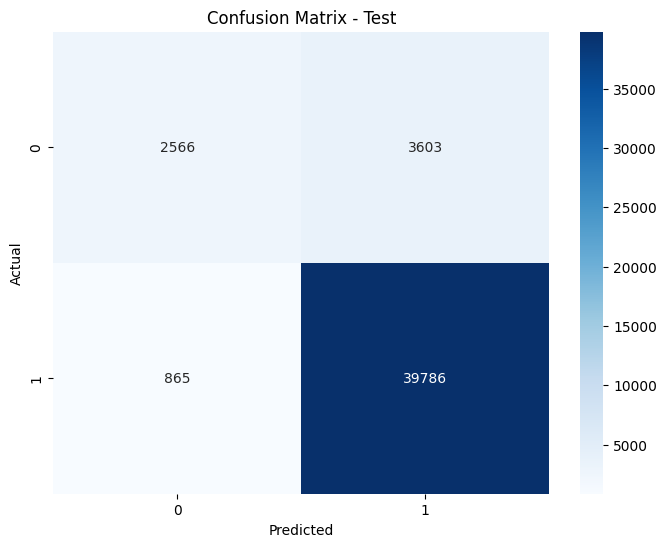

1464/1464 [==============================] - 14s 9ms/step


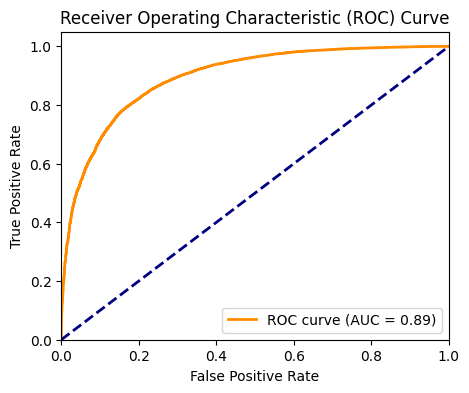

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.utils import set_random_seed
from keras.optimizers import Adam

set_random_seed(36)

# Load your data
X = wv.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = wv['overall']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))  # Adjust input_shape based on your data
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 neuron for binary classification

# Compile the model
model.compile(optimizer=Adam(lr = 0.3), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_pred_proba = model.predict(X_test)

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)

roc_auc = get_roc_auc(y_test, y_pred_proba)

scores_data.append(['RNN', 'CBOW']+[accuracy, precision, recall, f1, roc_auc])


#### RNN - Skipgram

Epoch 1/10


2024-03-16 20:40:34.265961: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 39s 26ms/step - loss: 0.3666 - accuracy: 0.8676 - val_loss: 0.3375 - val_accuracy: 0.8673
Epoch 2/10
1464/1464 [==============================] - 38s 26ms/step - loss: 0.3284 - accuracy: 0.8712 - val_loss: 0.3104 - val_accuracy: 0.8760
Epoch 3/10
1464/1464 [==============================] - 38s 26ms/step - loss: 0.3088 - accuracy: 0.8790 - val_loss: 0.3377 - val_accuracy: 0.8642
Epoch 4/10
1464/1464 [==============================] - 37s 26ms/step - loss: 0.2927 - accuracy: 0.8858 - val_loss: 0.2770 - val_accuracy: 0.8932
Epoch 5/10
1464/1464 [==============================] - 38s 26ms/step - loss: 0.2862 - accuracy: 0.8875 - val_loss: 0.2690 - val_accuracy: 0.8948
Epoch 6/10
1464/1464 [==============================] - 38s 26ms/step - loss: 0.2824 - accuracy: 0.8886 - val_loss: 0.2625 - val_accuracy: 0.8985
Epoch 7/10
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2575 - accuracy: 0.8992 - val_loss: 0.2422 - val_accura

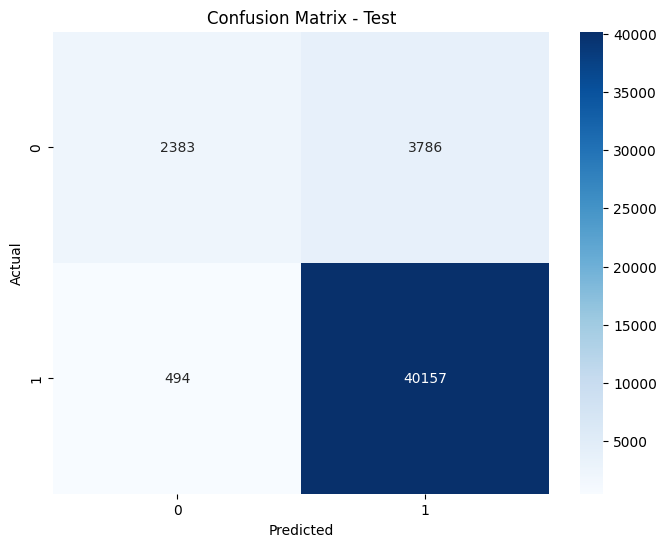

1464/1464 [==============================] - 15s 10ms/step


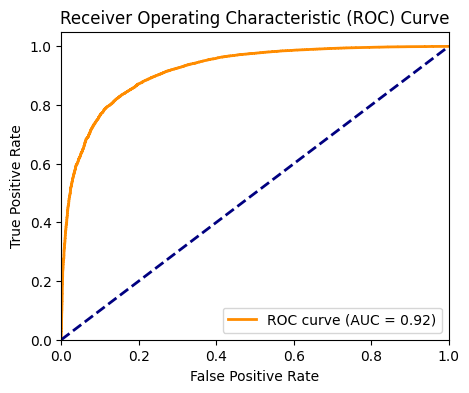

In [6]:
set_random_seed(42)

# Load your data
X = sg.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = sg['overall']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))  # Adjust input_shape based on your data
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 neuron for binary classification

# Compile the model
model.compile(optimizer=Adam(lr = 0.6), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_pred_proba = model.predict(X_test)

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)
roc_auc = get_roc_auc(y_test, y_pred_proba)

scores_data.append(['RNN', 'Skipgram']+[accuracy, precision, recall, f1, roc_auc])



#### RNN - Fasttext

Epoch 1/15


2024-03-16 20:47:22.365686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1464/1464 [==============================] - 39s 26ms/step - loss: 0.3706 - accuracy: 0.8682 - val_loss: 0.3470 - val_accuracy: 0.8683
Epoch 2/15
1464/1464 [==============================] - 39s 26ms/step - loss: 0.3280 - accuracy: 0.8735 - val_loss: 0.2995 - val_accuracy: 0.8885
Epoch 3/15
1464/1464 [==============================] - 37s 26ms/step - loss: 0.2871 - accuracy: 0.8888 - val_loss: 0.2900 - val_accuracy: 0.8936
Epoch 4/15
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2626 - accuracy: 0.8989 - val_loss: 0.2514 - val_accuracy: 0.9049
Epoch 5/15
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2554 - accuracy: 0.9008 - val_loss: 0.2432 - val_accuracy: 0.9091
Epoch 6/15
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2434 - accuracy: 0.9062 - val_loss: 0.2301 - val_accuracy: 0.9142
Epoch 7/15
1464/1464 [==============================] - 37s 25ms/step - loss: 0.2347 - accuracy: 0.9104 - val_loss: 0.2244 - val_accura

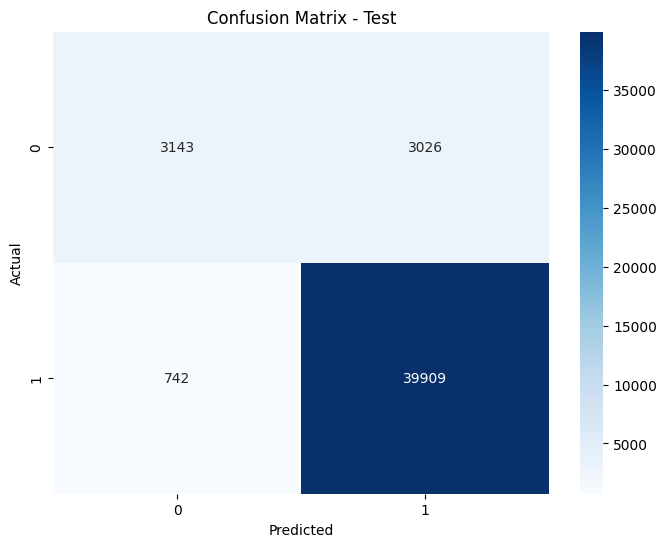

1464/1464 [==============================] - 14s 9ms/step


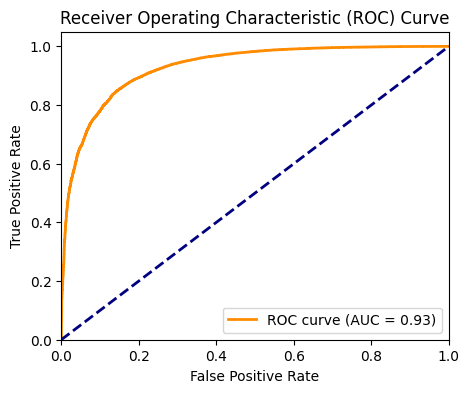

In [7]:
set_random_seed(42)

# Load your data
X = ft.drop(['overall','reviewText', 'preprocessed_text', 'embeddings'], axis = 1)
y = ft['overall']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)



model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))  # Adjust input_shape based on your data
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 neuron for binary classification

# Compile the model
model.compile(optimizer=Adam(lr = 0.7), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_pred_proba = model.predict(X_test)

accuracy, precision, recall, f1 = calc_metrics(y_test, y_pred)
roc_auc = get_roc_auc(y_test, y_pred_proba)


scores_data.append(['RNN', 'Fasttext']+[accuracy, precision, recall, f1, roc_auc])



In [8]:
scores = pd.DataFrame(data = scores_data, columns = ['model', 'embedding','accuracy','precision','recall','f1 score','roc auc'])
scores

,model,embedding,accuracy,precision,recall,f1 score,roc auc
0,XGBoost,CBOW,0.907582,0.955553,0.937148,0.946261,0.927467
1,XGBoost,Skipgram,0.906408,0.954807,0.936533,0.945581,0.925792
2,XGBoost,Fasttext,0.907283,0.954944,0.937443,0.946113,0.926295
3,CNN,CBOW,0.844212,0.950369,0.865784,0.906107,0.783922
4,CNN,Skipgram,0.870355,0.887011,0.974859,0.928863,0.578287
5,CNN,Fasttext,0.870419,0.875423,0.991907,0.930032,0.537012
6,RNN,CBOW,0.904571,0.916961,0.978721,0.946835,0.894167
7,RNN,Skipgram,0.908586,0.913843,0.987848,0.949405,0.919373
8,RNN,Fasttext,0.919522,0.929521,0.981747,0.954921,0.928782


In [9]:
scores.to_csv('model_scores.csv', index = False)

## 4. Result Analysis

In [15]:
scores = pd.read_csv('model_scores.csv')

In [16]:
scores['method'] = scores['model'] + '-' + scores['embedding']
scores.drop(['model', 'embedding'], inplace = True, axis = 1)
scores

,accuracy,precision,recall,f1 score,roc auc,method
0,0.907582,0.955553,0.937148,0.946261,0.927467,XGBoost-CBOW
1,0.906408,0.954807,0.936533,0.945581,0.925792,XGBoost-Skipgram
2,0.907283,0.954944,0.937443,0.946113,0.926295,XGBoost-Fasttext
3,0.844212,0.950369,0.865784,0.906107,0.783922,CNN-CBOW
4,0.870355,0.887011,0.974859,0.928863,0.578287,CNN-Skipgram
5,0.870419,0.875423,0.991907,0.930032,0.537012,CNN-Fasttext
6,0.904571,0.916961,0.978721,0.946835,0.894167,RNN-CBOW
7,0.908586,0.913843,0.987848,0.949405,0.919373,RNN-Skipgram
8,0.919522,0.929521,0.981747,0.954921,0.928782,RNN-Fasttext


- We can see that the accuracy, precision, recall and f1 scores are almost more than 85% in every case. But this is only due to the fact that data is highly imbalanced.
- The ROC AUC curve and value provides an accurate picture of how the models are performing. 
- We can see that the machine learning algorithm XGBoost performs really well.
- However, the best performing model is RNN with Fasttext embeddings.

In [43]:
metrics = ['accuracy', 'precision', 'recall', 'f1 score', 'roc auc']

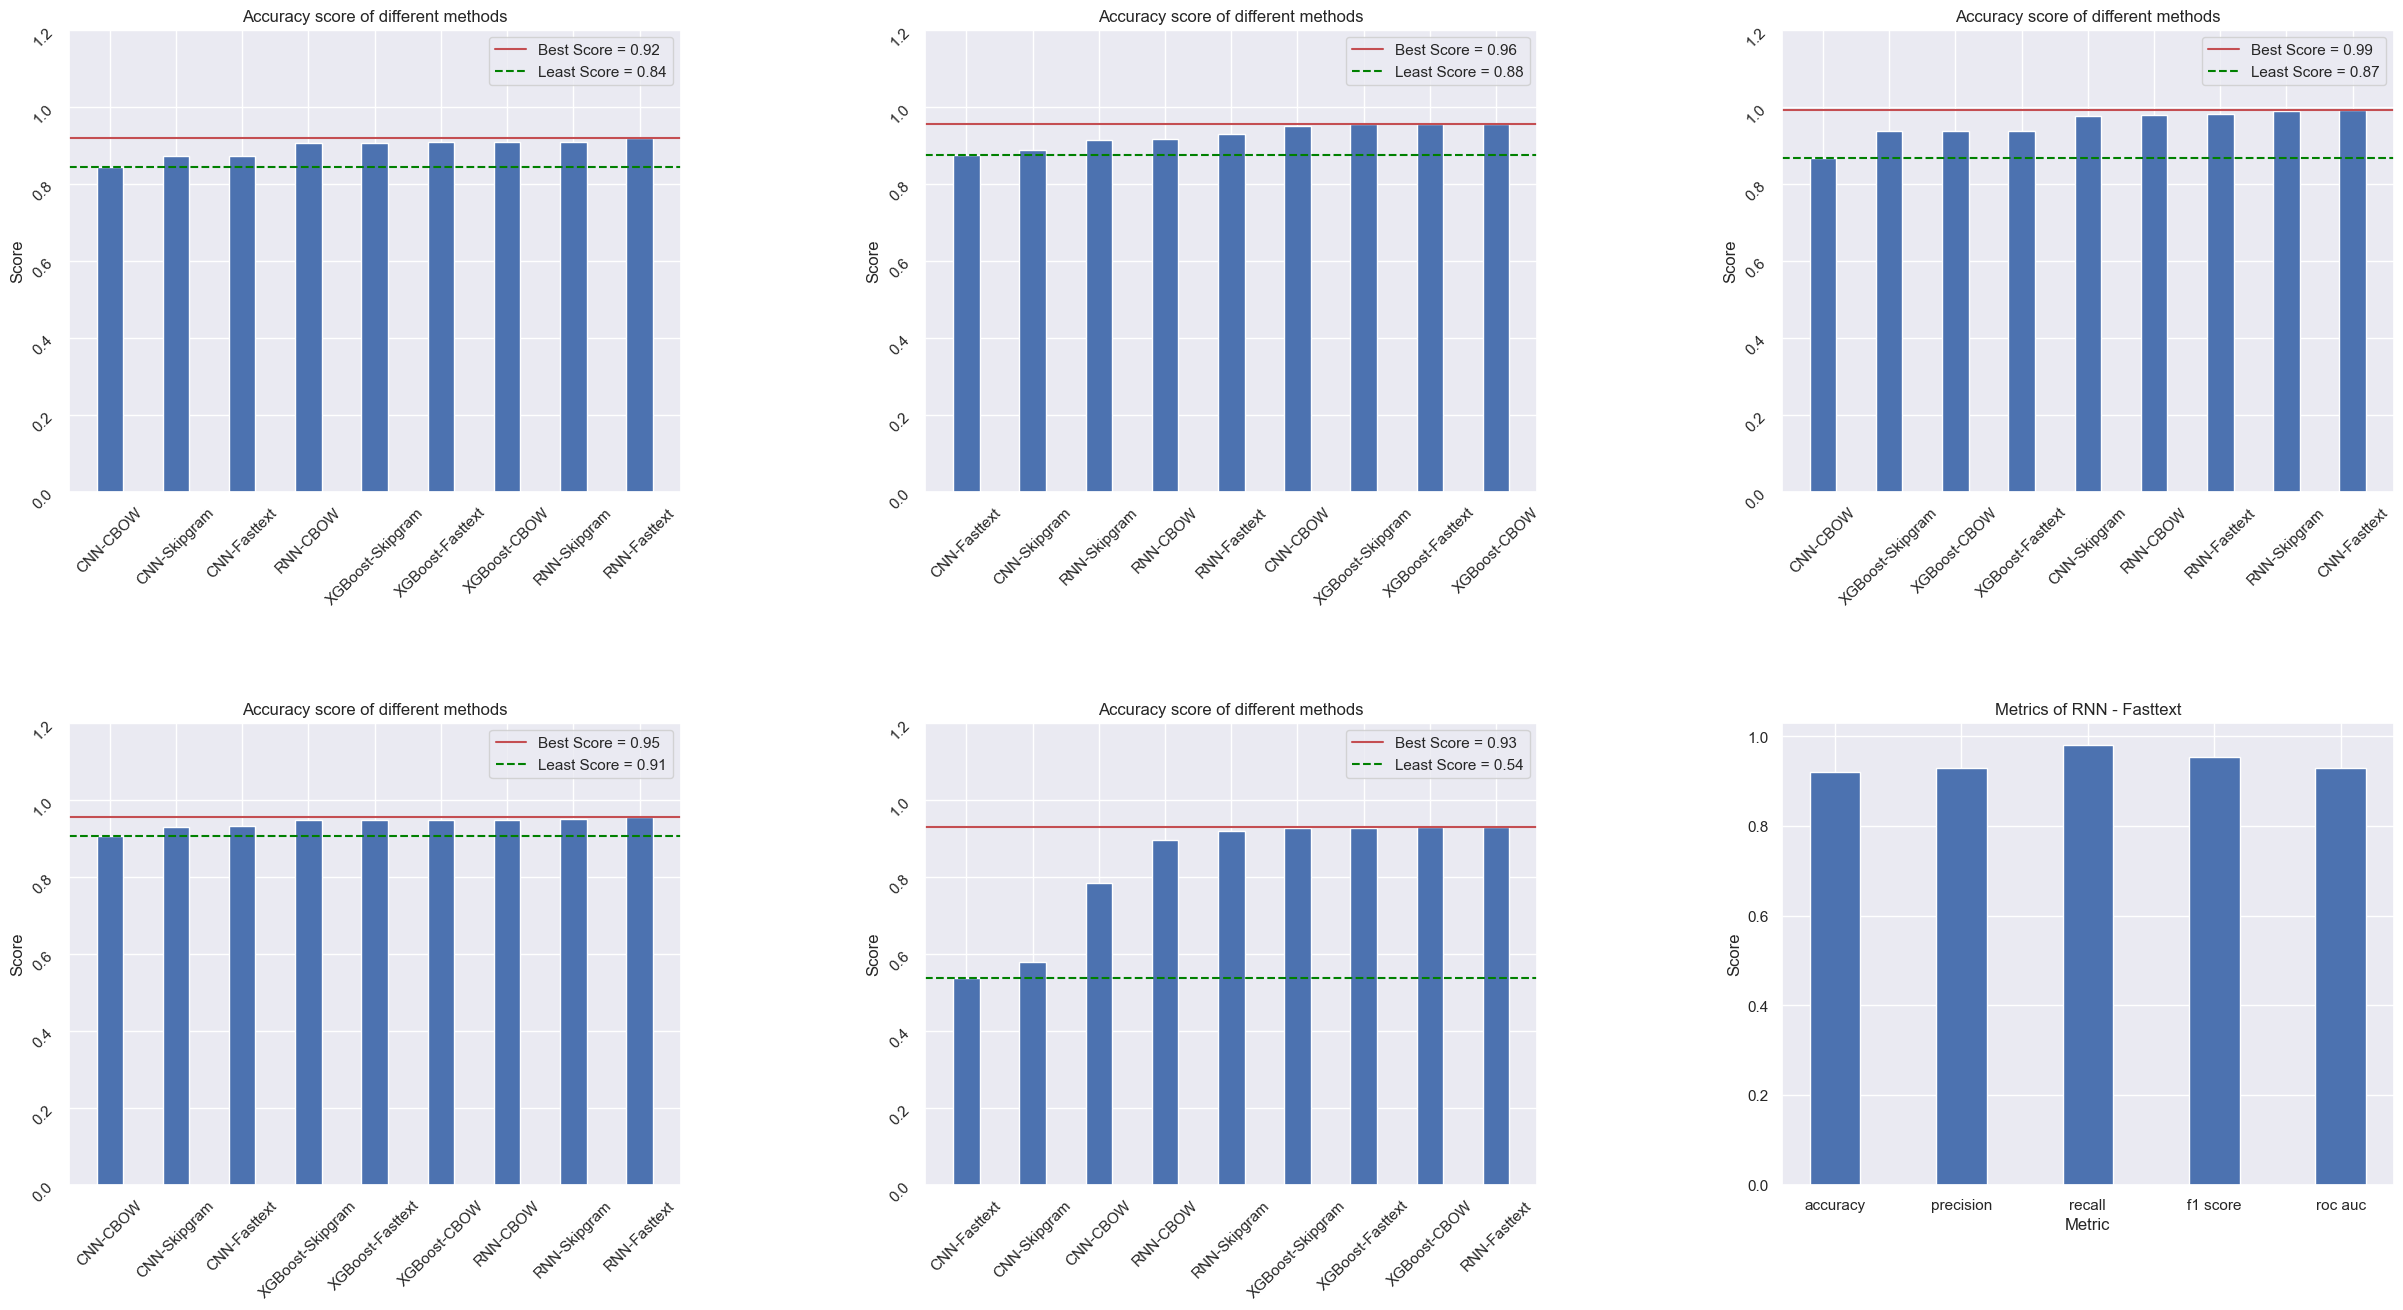

In [77]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))

for i in range(len(metrics)):
    sns.set_theme(style = 'darkgrid')
    best_acc = scores[['method', metrics[i]]].sort_values([metrics[i]])

    axes[i//3][i%3].bar(best_acc['method'], best_acc[metrics[i]], width = 0.4)
    axes[i//3][i%3].axhline(y = best_acc[metrics[i]].max(), color='r', linestyle='-', label = f'Best Score = {"{:.2f}".format(best_acc[metrics[i]].max())}')
    axes[i//3][i%3].axhline(y = best_acc[metrics[i]].min(), color='green', linestyle='--', label = f'Least Score = {"{:.2f}".format(best_acc[metrics[i]].min())}')

    axes[i//3][i%3].tick_params(labelrotation=45)
    axes[i//3][i%3].set_ylim(0, 1.2)
    axes[i//3][i%3].set_ylabel('Score')
    axes[i//3][i%3].set_title('Accuracy score of different methods')
    axes[i//3][i%3].legend()

x = scores[scores['method'] == 'RNN-Fasttext'].to_numpy().tolist()[0][:5]
axes[1][2].bar(metrics, x, width = 0.4)
axes[1][2].set_xlabel('Metric')
axes[1][2].set_ylabel('Score')
axes[1][2].set_title('Metrics of RNN - Fasttext')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
    
plt.show()


1464/1464 [==============================] - 14s 9ms/step


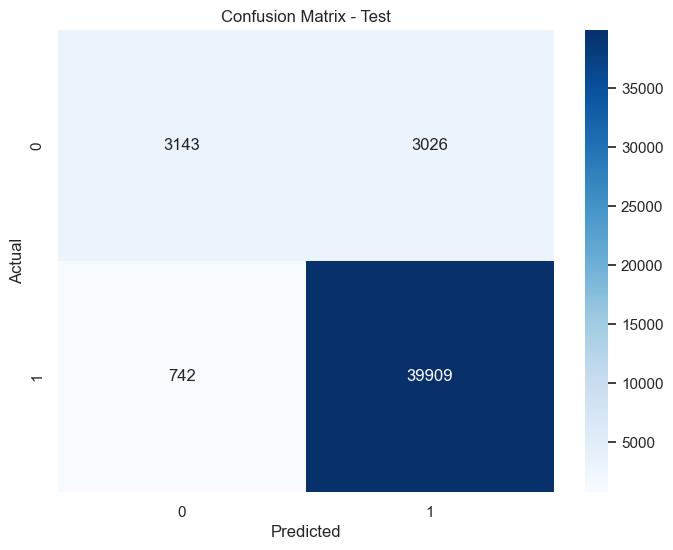

In [82]:
#In the execution flow, RNN-Fasttext is the last one executed. Hence "model" has the best required model

X = ft.drop(['overall', 'embeddings'], axis = 1)
y = ft['overall']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

y_pred = model.predict(X_test.drop(['reviewText','preprocessed_text'], axis = 1))
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Using VADAR and TextBlob

In [96]:
'''
import nltk
nltk.download('vader_lexicon')
'''

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/saideepbunny/nltk_data...


True

In [185]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

si = SentimentIntensityAnalyzer()

In [186]:
test_result = X_test[['reviewText', 'preprocessed_text']]
test_result['actual'] = y_test
test_result['predicted'] = y_pred
good_predictions = test_result[(test_result['actual'] == 0) | (test_result['actual'] == 1)]
good_predictions.head(5)

,reviewText,preprocessed_text,actual,predicted
131193,THis game is downright boring. The story is t...,game downright boring story terrible missions ...,0,0
230939,I've been a die-hard fan of Eagle One Nevr-Dul...,die hard fan eagle one nevr dull thought would...,1,1
220324,"I put my sports car to bed in the winter, batt...",put sports car bed winter battery would dead c...,1,1
6116,T2- The Arcade game is a great arcade rail sho...,arcade game great arcade rail shooter ported s...,1,1
52687,I love Mario Kart it is so fun.I had this on N...,love mario kart fun nintendo but not think n w...,1,1


In [187]:
greviews = good_predictions.head(3).to_dict('records')

In [188]:
review1 = greviews[0]
print(review1)
print()
print('VADAR:',si.polarity_scores(review1['reviewText']))
print()
print('TextBlob:',TextBlob(review1['reviewText']).sentiment)

{'reviewText': 'THis game is downright boring.  The story is terrible, the missions are dumb, the gameplay is extremely repetitive and unoriginal.  The one thing this game has going for it is the graphics. The graphics are pretty decent for a game that sucks so bad.', 'preprocessed_text': 'game downright boring story terrible missions dumb gameplay extremely repetitive unoriginal one thing game going graphics graphics pretty decent game sucks bad', 'actual': 0, 'predicted': 0}

VADAR: {'neg': 0.314, 'neu': 0.63, 'pos': 0.056, 'compound': -0.9298}

TextBlob: Sentiment(polarity=-0.3840277777777778, subjectivity=0.5569444444444446)


- There are negative words like boring, terrible, dumb, unoriginal, sucks, bad vs pretty, decent as good words. Therefore model predicted this as a bad review.

- Still, Vadar gave it a neutral score of 0.63 which is surprising.

In [189]:
review2 = greviews[1]
print(review2)
print()
print('VADAR:',si.polarity_scores(review2['reviewText']))
print()
print('TextBlob:',TextBlob(review2['reviewText']).sentiment)

{'reviewText': "I've been a die-hard fan of Eagle One Nevr-Dull and thought this would provide the perfect test environment to put Griot's against.  I used it on my Harley polished stainless and chrome, and it cleaned them up BRILLIANTLY!  Don't get me wrong, I love Nevr-Dull and it's hard to do 'one better.'  But I believe the Griot's polish did a little bit better job than the Nevr-Dull, and -- this is the big part -- it's nice not to have to polish an entire motorcycle pinching a cotton ball.The hard thing about any polish is that it totally depends on how dirty something is to begin with before you can rate the performance.  I keep my stuff clean and it still took a bit of elbow grease, but nothing unusual.  Likewise, it doesn't take a lot of polish to get the metal sparkling again.In the end, this is a bit more expensive than Nevr-Dull, but I feel it's worth the additional cost.  I barely put a dent in this bottle so I know it's going to last a bit before I need to replace it.  I 

- There are words like perfect, brilliantly, better, nice, outstanding, and others but any negative words. 
- Therefore the model predicts this as good review.

In [199]:
def get_sentiment(text):
    si = SentimentIntensityAnalyzer()
    vadar = si.polarity_scores(text)
    textblob = TextBlob(text).sentiment.polarity
    return list(vadar.values())[:3] + [textblob]


In [200]:
#Lets look at the whole picture

good_predictions['sentiment'] = good_predictions['reviewText'].apply(lambda x: get_sentiment(x))
good_predictions['negative'] = good_predictions['sentiment'].str[0]
good_predictions['neutral'] = good_predictions['sentiment'].str[1]
good_predictions['positive'] = good_predictions['sentiment'].str[2]
good_predictions['textblob_polarity'] = good_predictions['sentiment'].str[3]

good_predictions.head()


,reviewText,preprocessed_text,actual,predicted,sentiment,negative,neutral,positive,textblob_polarity
131193,THis game is downright boring. The story is t...,game downright boring story terrible missions ...,0,0,"[0.314, 0.63, 0.056, -0.3840277777777778]",0.314,0.630,0.056,-3.840278e-01
230939,I've been a die-hard fan of Eagle One Nevr-Dul...,die hard fan eagle one nevr dull thought would...,1,1,"[0.027, 0.777, 0.196, 0.1978333333333333]",0.027,0.777,0.196,1.978333e-01
220324,"I put my sports car to bed in the winter, batt...",put sports car bed winter battery would dead c...,1,1,"[0.157, 0.803, 0.04, -0.2]",0.157,0.803,0.040,-2.000000e-01
6116,T2- The Arcade game is a great arcade rail sho...,arcade game great arcade rail shooter ported s...,1,1,"[0.0, 0.756, 0.244, 9.25185853854297e-18]",0.000,0.756,0.244,9.251859e-18
52687,I love Mario Kart it is so fun.I had this on N...,love mario kart fun nintendo but not think n w...,1,1,"[0.032, 0.633, 0.335, 0.2997835497835498]",0.032,0.633,0.335,2.997835e-01


In [202]:
#True positives
req = ['negative','neutral','positive','textblob_polarity']

good_predictions[good_predictions['predicted'] == 1][req].describe()

,negative,neutral,positive,textblob_polarity
count,42935.000000,42935.000000,42935.000000,42935.000000
mean,0.056875,0.747016,0.196110,0.155238
std,0.053989,0.099816,0.101723,0.177311
min,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.694000,0.129000,0.050000
50%,0.049000,0.756000,0.178000,0.132639
75%,0.086000,0.811000,0.247000,0.237865
max,0.557000,1.000000,1.000000,1.000000


- Vadar gives a mean neutral score as 0.74. But textblob polarity has a score of 0.15.

- the positive and negative vadar scores have a difference of 0.14.

In [204]:
#True Negatives
good_predictions[good_predictions['predicted'] == 0][req].describe()

,negative,neutral,positive,textblob_polarity
count,3885.000000,3885.000000,3885.000000,3885.000000
mean,0.121558,0.767232,0.111207,-0.055950
std,0.074377,0.087817,0.062442,0.176895
min,0.000000,0.227000,0.000000,-1.000000
25%,0.073000,0.716000,0.071000,-0.138571
50%,0.112000,0.770000,0.107000,-0.040859
75%,0.158000,0.824000,0.146000,0.040000
max,0.773000,1.000000,0.474000,1.000000


- Vadar is not showing the correct info here and even textblob polarity.

In [228]:
test_result = X_test[['reviewText', 'preprocessed_text']]
test_result['actual'] = y_test
test_result['predicted'] = y_pred
bad_predictions = test_result[test_result['actual'] != test_result['predicted']]
bad_predictions.head(5)

,reviewText,preprocessed_text,actual,predicted
214542,"It's a beautiful day here in New Orleans, calm...",beautiful day new orleans calm breeze barely s...,0,1
136386,Call of Duty Quality as expected... If you are...,call duty quality expected looking sort story ...,0,1
99108,This game was great when it was first released...,game great when first released almost years ag...,0,1
90075,its a controller. whats there to say about it?...,controller what say paid got,1,0
96195,"Honestly, I thought I was getting an incredibl...",honestly thought getting incredible bargain bu...,0,1


In [229]:
reviews = bad_predictions.head(11).to_dict('records')


In [230]:
review1 = reviews[0]
print(review1)
print()
print('VADAR:',si.polarity_scores(review1['reviewText']))
print()
print('TextBlob:',TextBlob(review1['reviewText']).sentiment)

{'reviewText': "It's a beautiful day here in New Orleans, calm, the breeze is barely stirring, and yet the slight breeze is enough to de-perk my perky bird waterer. This is actually really cute, I hung it on a plant hanger and it looks cute in the yard. I noticed the perky waterer seems very flimsy but I hung it up anyway.The waterer, in theory, will be filled by rain, but if I hang it in a tree the branches would interfere, plus, here in New Orleans, rain is usually accompanied by wind, so this would be flying around and spilling out instead of filling up.I saw a bird trying to land and drink and the waterer swung around like a carnival ride, the bird looked confused and so am I. This is so light weight and ever time it swings just a little water drips out this way and that. I have filled it four times since hanging it up yesterday. Neither the birds nor I are impressed with this bird waterer.", 'preprocessed_text': 'beautiful day new orleans calm breeze barely stirring yet slight bre

- This review does not have negative words but carefully addresses a problem about the waterer. The model might not have identified this.

In [231]:
review2 = reviews[1]
print(review2)
print()
print('VADAR:',si.polarity_scores(review2['reviewText']))
print()
print('TextBlob:',TextBlob(review2['reviewText']).sentiment)

{'reviewText': 'Call of Duty Quality as expected... If you are looking for any sort of story obviously DO NOT buy this game! CoD has been lacking in writing more and more as the years go by, and this game is no exception. Ghosts is a very poor story behind the single player, and graphics are not as they should have been for their next release. True most people buy this for the online experience but that too comes up extremely short. The game play is obviously the same as the past 3 releases and they hardly gave any (if any at all) new weapons or modes. If you are looking for a FPS that is EXACTLY the same as the past CoD then yes Ghosts would be a good match for you, but if you want something with any sort of replay value or anything new stray from this title! I for one have had enough with all the teenagers and college drop outs that act as if they are in the military (from their parents house) barking commands and screaming online. As long as you have a group of friends you can creat

- This is a straight bad review. The key words in this review might have showed up moslty in good reviews and therefore the model predicted this way.

In [232]:
review3 = reviews[10]
print(review3)
print()
print('VADAR:',si.polarity_scores(review3['reviewText']))
print()
print('TextBlob:',TextBlob(review3['reviewText']).sentiment)

{'reviewText': 'I put a few hours in on singleplayer, and am now not sure how to start another separate game for local co op, PLEASE HELP! Can I start a multiplayer game with a new character and not have it effect my singleplayer game save? I don\'t see the option where to start a local game now that I have begun a singleplayer game, all I see is the "continue" option.Save me!!!!', 'preprocessed_text': 'put few hours singleplayer not sure start another separate game local co op please help start multiplayer game new character not effect singleplayer game save not see option where start local game begun singleplayer game see continue option save', 'actual': 1, 'predicted': 0}

VADAR: {'neg': 0.028, 'neu': 0.817, 'pos': 0.155, 'compound': 0.8712}

TextBlob: Sentiment(polarity=-0.28901988636363635, subjectivity=0.3443434343434343)


- This is more of a follow up query than a review of the game. And the keywords here might be in favour of model saying that this is negative review.

- We can see that, 3 above samples from the bad predictions have high neutral sentiment according to VADAR.
- This is complimented by even the textblob's sentiment as well. 

In [196]:
#Lets look at the whole picture

bad_predictions['sentiment'] = bad_predictions['reviewText'].apply(lambda x: get_sentiment(x))
bad_predictions['negative'] = bad_predictions['sentiment'].str[0]
bad_predictions['neutral'] = bad_predictions['sentiment'].str[1]
bad_predictions['positive'] = bad_predictions['sentiment'].str[2]
bad_predictions['textblob_polarity'] = bad_predictions['sentiment'].str[3]

bad_predictions.head()


,reviewText,preprocessed_text,actual,predicted,sentiment,negative,neutral,positive,textblob_polarity
214542,"It's a beautiful day here in New Orleans, calm...",beautiful day new orleans calm breeze barely s...,0,1,"[0.037, 0.895, 0.069, 0.22756238859180036]",0.037,0.895,0.069,0.227562
136386,Call of Duty Quality as expected... If you are...,call duty quality expected looking sort story ...,0,1,"[0.06, 0.784, 0.156, 0.025790764790764788]",0.060,0.784,0.156,0.025791
99108,This game was great when it was first released...,game great when first released almost years ag...,0,1,"[0.121, 0.704, 0.175, 0.13901515151515156]",0.121,0.704,0.175,0.139015
90075,its a controller. whats there to say about it?...,controller what say paid got,1,0,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.000000
96195,"Honestly, I thought I was getting an incredibl...",honestly thought getting incredible bargain bu...,0,1,"[0.057, 0.834, 0.11, 0.07563025210084033]",0.057,0.834,0.110,0.075630


In [197]:
bad_predictions[['negative','neutral','positive','textblob_polarity']].describe()

,negative,neutral,positive,textblob_polarity
count,3768.000000,3768.000000,3768.000000,3768.000000
mean,0.094327,0.778954,0.126723,0.028629
std,0.064120,0.089214,0.070127,0.163043
min,0.000000,0.207000,0.000000,-1.000000
25%,0.053000,0.726000,0.082000,-0.053565
50%,0.086000,0.783000,0.123000,0.028782
75%,0.128000,0.835250,0.167000,0.114563
max,0.490000,1.000000,0.544000,1.000000


- We can see that these bad predictions have a mean neutral score of 0.77 and mean textblob polarity of 0.02 (neutral).
- Difference between mean positive and mean negative is 0.036. Comparatively more inclined towards positive.
- This indicates that these review might actually be neutral. This means the reviews either dont have strong words that make them either positive or negative. Another possibility is that the reviews have both strong positive and strong negative words.
- When we see the bad prediction reviewText printed above support this theory.

- But, above, we saw that the True Negatives and the False Negative both are shown to be Neutral as per vadar and textblob.
- One possibility is that there might be more bad reviews in the data that have both positive and negative words as well.
- The model was able to capture a porting of it but vadar might be capable of only saying it as neutral.